In [3]:
import nrl

In [ ]:
%load_ext autoreload
%autoreload 2
from .. frozen_lake import *
from climate_control import *
import numpy as np, numpy.random as nr, gym
from itertools import product
import matplotlib.pyplot as plt
%matplotlib inline

# Seed RNGs so you get the same printouts as me
# env.seed(0)
from gym.spaces import prng; prng.seed(10)

NUM_ITER = 75
GAMMA = 0.95

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ImportError: No module named envs.frozen_lake

In [2]:
def compute_Q(T_s, V, gamma):
            Q = {}
            for a in T_s:
                Q_sa = sum(
                    [sas[0]*(sas[2] + gamma*V[sas[1]]) for sas in T_s[a]])
                Q[a] = Q_sa
            return Q
        
def normalize(*args):
    normalized = []
    total = sum(args)
    for arg in args:
        normalized.append(arg / total)
    return tuple(normalized)


#Only works with gridworld environments
def plot_gridworld_values(mdp,V, pi, s=None, title=None):
    V = V.reshape(mdp.nrow, mdp.ncol)
    plt.figure(figsize=(3,3))
    if title != None:
        plt.title(title)
    plt.imshow(V, cmap='gray')#, clim=(0,1)) 'gist_ncar'
    ax = plt.gca()
    ax.set_xticks(np.arange(V.shape[1])-.5)
    ax.set_yticks(np.arange(V.shape[0])-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:V.shape[0], 0:V.shape[1]]
    a2uv = {0: (-1, 0), 1:(0, -1), 2:(1,0), 3:(0, 1)}
    Pi = pi.reshape(V.shape)
    for y in range(V.shape[0]):
        for x in range(V.shape[1]):
            a = Pi[y, x]
            u, v = a2uv[a]
            plt.arrow(x, y,u*.3, -v*.3, color='m', head_width=0.1, head_length=0.1) 
            plt.text(x, y, str(mdp.desc[y,x].item().decode()),
                     color='g', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
    if s != None:
        plt.plot(s%V.shape[0], s//V.shape[0], 'ro')
    plt.grid(color='b', lw=2, ls='-')
    return

def plot_climate(temps, max_temp, title=None):
    plt.figure(figsize=(7,3))
    if title != None:
        plt.title(title)
    temps = list(temps) + [0] * (6 - len(temps))
    temp_mat = np.array([
        [0,0,temps[1],temps[3],temps[3],temps[5],temps[5]],
        [temps[0],temps[0],temps[1],temps[3],temps[3],temps[5],temps[5]],
        [temps[0],temps[0],temps[2],temps[4],temps[4],temps[4],temps[4]]
    ])
    temp_mat = temp_mat / max_temp
    plt.imshow(temp_mat, cmap='inferno', clim=(0,1)) # 'gist_ncar'
    labels = [(0,1,1),(2,0,2),(2,2,3),(3,0,4),(4,2,5),(5,0,6)]
    for x,y,label in labels:
        plt.text(x, y, str(label), color='g', size=12,  verticalalignment='center',
                 horizontalalignment='center', fontweight='bold')
    return

In [4]:
def construct_TR(mdp, pi):
    T = np.zeros([mdp.nS, mdp.nS])
    R = np.zeros([mdp.nS])
    for s in range(mdp.nS):
        t = mdp.P[s][pi[s]]
        for ret in t:
            T[s][ret[1]] = ret[0]
            R[s] += ret[2] * ret[0]
    return T,R


def eval_pol(mdps,pi,gamma=GAMMA):
    Vs = []
    for mdp in mdps:
        T, R = construct_TR(mdp, pi)
        Vs += [np.linalg.solve(np.eye(mdp.nS) - gamma*T, R)]
    return Vs

def update_pol(mdps, Vs, ws, gamma=GAMMA):
    pi = np.zeros([mdps[0].nS])
    for s in range(mdps[0].nS):
        Qs_s = [compute_Q(mdps[i].P[s], Vs[i], gamma) for i in range(len(mdps))]
        mixed_q_s = {a: sum([ws[i] * Qs_s[i][a] for i in range(len(mdps))]) for a in Qs_s[0]}
        pi[s] = max(mixed_q_s, key=lambda x: mixed_q_s[x])
    return pi

In [5]:
def find_diffs(mdps):
    assert(len(set([mdp.nS for mdp in mdps])) == 1 and len(set([mdp.nA for mdp in mdps])) == 1)
    
    I = len(mdps)
    Ps = [mdp.P for mdp in mdps]
    nS, nA = mdps[0].nS, mdps[0].nA
    q_tuples = []
    obs_tuples = []
    obs_dicts = [{} for _ in range(I)]
    max_rewards = [0] * I
    for s in range(nS):
        for a in range(nA):
            q_added = False
            sp_dicts = [{tup[1] : tup for tup in P[s][a]} for P in Ps]
            sprimes = set([sprime for sp_dict in sp_dicts for sprime in sp_dict]) 
            for sprime in sprimes:
                tups = [sp_dict[sprime] if sprime in sp_dict else (1e-16,sprime,0.0) for sp_dict in sp_dicts]
                diff = len(set([(tup[0],tup[1]) for tup in tups])) != 1
                if diff:
                    if not q_added:
                        q_tuples += [(s,a)]
                        q_added = True
                    obs_tuples += [(s,a,sprime)]
                    for i in range(I):
                        if tups[i] == (0.0,0.0):
                            reward_func = getattr(mdps[i], "reward", lambda *_:0.0)
                            p = 0.0
                            r = reward_func(s,a,sprime)
                        else:
                            p,r = tups[i][0], tups[i][2]
                        obs_dicts[i][(s,a,sprime)] = (p,r)
                for i in range(I):
                    max_rewards[i] = max(max_rewards[i], tups[i][2])
    return q_tuples, obs_tuples, obs_dicts, max_rewards
            
    

def construct_special_TR(mdp, pol, partial_Qs, q_tuples):
    T = np.zeros([mdp.nS + 1, mdp.nS + 1])
    R = np.zeros([mdp.nS + 1])
    for s in range(mdp.nS):
        if (s,pol[s]) in q_tuples:
            # Transition all probability mass to sink state
            R[s] += partial_Qs[q_tuples.index((s,pol[s]))]
            T[s][mdp.nS] = 1
        else:
            t = mdp.P[s][pol[s]]
            for ret in t:
                T[s][ret[1]] += ret[0]
                R[s] += ret[2] * ret[0]
    T[mdp.nS][mdp.nS] = 1
    return T,R

def naive_mixed_policy_iteration(mdps, ws, gamma=GAMMA, max_iter=100):
#     pol = np.array([np.random.choice(range(mdp.nA)) for _ in range(mdp.nS)])
    Vs = [np.zeros(mdp.nS) for mdp in mdps] 
    pol_history = []
    for i in range(max_iter):
        pol = update_pol(mdps, Vs, ws, gamma=gamma)
        Vs = eval_pol(mdps, pol, gamma=gamma)
        if True in [np.array_equal(pol, hist) for hist in pol_history]:
            break
        else:
            pol_history += [pol]

    return pol, Vs

In [6]:
def augmented_policy_iteration(mdps, ws, backupQs, q_tuples, gamma):
    
    S = mdps[0].nS
    
    def compute_Q(mdp, s, V, backupQ):
            Q = {}
            for a in mdp.P[s]:
                if (s,a) in q_tuples:
                    Q_sa = backupQ[q_tuples.index((s,a))]
                else:
                    Q_sa = sum([sas[0]*(sas[2] + gamma*V[sas[1]]) for sas in mdp.P[s][a]])
                Q[a] = Q_sa
            return Q
    
#     def update_vals(pol, Vs):
#         newVs = []
#         for i in range(len(mdps)):
#             T, R = construct_special_TR(mdps[i], pol, backupQs[i], q_tuples)
#             newVs += [R + gamma * T.dot(Vs[i])]
#         return newVs
    
    def eval_pol(pol):
        Vs = []
        for i,mdp in enumerate(mdps):
            T, R = construct_special_TR(mdp, pol, backupQs[i], q_tuples)
            Vs += [np.linalg.solve(np.eye(mdp.nS+1) - gamma*T, R)[:mdp.nS]]
        return Vs


    def update_pol(Vs):
        pol = np.zeros(S)
        for s in range(S):
            Qs_s = [compute_Q(mdps[i], s, Vs[i], backupQs[i]) for i in range(len(mdps))]
            mixed_q_s = {a: sum([ws[i] * Qs_s[i][a] for i in range(len(mdps))]) for a in Qs_s[0]}
            pol[s] = max(mixed_q_s, key=lambda x: round(mixed_q_s[x],11))
        return pol
    
    pol = np.zeros(S)
    prevPol = pol
    Vs = eval_pol(pol)
    pol = update_pol(Vs)
    
    while not np.array_equal(prevPol, pol):
        prevPol = pol
        Vs = eval_pol(pol)
        pol = update_pol(Vs)
        
    return pol, Vs

In [18]:
def approximate_NOC_err(mdps, ws=None, horizon=2, gamma=GAMMA, values=False):
    q_tuples,O, obs_dicts, max_rewards = find_diffs(mdps)
    S = mdps[0].nS
    I = len(mdps)
    base_error = max(max_rewards)
    if hasattr(mdps[0],"max_steps"):
        base_error *= 1/(1-gamma) # limited to 1 reward sink states
    
    # Construct uninitialized Q-value backups for each agent for each combination of observations for each time-step
    # Ex: backup of shape DxDxIxQ for time-step 2
    # D=number of different transitions between mdps, Q=number of different Q-values, I=number of agents
    qlo_backups = {i:np.zeros(tuple([len(O) for _ in range(i)] + [I,len(q_tuples)])) for i in range(horizon-1)}
    qhi_backups = {i:np.zeros(tuple([len(O) for _ in range(i)] + [I,len(q_tuples)])) for i in range(horizon-2)}
    qhi_backups[horizon-2] = np.ones(tuple([len(O) for _ in range(horizon-2)] + [I,len(q_tuples)])) * base_error
    ws = ws if ws != None else normalize(*([1]*I))
    conditional_plan = [None, {}] if not values else [None, {}, None, ws]
 
    def reweight(history):
        ps = list(ws)
        for i in range(I):
            for obs in history:
                ps[i] *= obs_dicts[i][obs][0]
        return normalize(*ps)
    
    def compute_val(mdp, pol, dist, prevQ=None):
        if prevQ == None:
            T, R = construct_TR(mdp, pol)
            V = np.linalg.solve((np.eye(mdp.nS)-gamma*T),R)
        else:
            T, R = construct_special_TR(mdp,pol,prevQ,q_tuples)
            V = np.linalg.solve((np.eye(mdp.nS+1)-gamma*T),R)[:mdp.nS]
        return V.dot(dist)
    
    for h in reversed(range(horizon)):
        for history in product(range(len(O)), repeat=h):
            temp_plan = conditional_plan
            if h == 0:
                tempws = ws
                Qhis = qhi_backups[h]
                Qlos = qlo_backups[h]
                polhi,Vhis = augmented_policy_iteration(mdps, tempws, Qhis, q_tuples, gamma)
                pollo,Vlos = augmented_policy_iteration(mdps, tempws, Qlos, q_tuples, gamma)
            else:
                obs_history = [O[i] for i in history]
                obs = obs_history[-1]
                tempws = reweight(obs_history)
                baseQ = (obs[0], obs[1])
                initial_dist = np.zeros((S))
                initial_dist[obs[2]] = 1.0
                if h != horizon-1:
                    Qhis = qhi_backups[h][history]
                    Qlos = qlo_backups[h][history]
                    polhi,Vhis = augmented_policy_iteration(mdps, tempws, Qhis, q_tuples, gamma)
                    pollo,Vlos = augmented_policy_iteration(mdps, tempws, Qlos, q_tuples, gamma)
                    for i in range(I):
                        p, rew = obs_dicts[i][obs]
                        Vlo = compute_val(mdps[i], pollo, initial_dist,Qlos[i])
                        qlo_backups[h-1][tuple(list(history[:-1]) + [i,q_tuples.index(baseQ)])] += p * (rew + gamma * Vlo)
                        Vhi = compute_val(mdps[i], pollo, initial_dist,Qhis[i])
                        qhi_backups[h-1][tuple(list(history[:-1]) + [i,q_tuples.index(baseQ)])] += p * (rew + gamma * Vhi)
                else:
                    Qlos = [None for _ in range(len(mdps))]
                    pollo,Vlos = naive_mixed_policy_iteration(mdps, tempws, gamma)
                    Vhis = Vlos
                    for i in range(I):
                        p, rew = obs_dicts[i][obs]
                        Vlo = compute_val(mdps[i], pollo, initial_dist,Qlos[i])
                        qlo_backups[h-1][tuple(list(history[:-1]) + [i,q_tuples.index(baseQ)])] += p * (rew + gamma * Vlo)
                    

                for ob in obs_history:
                    if ob not in temp_plan[1]:
                        temp_plan[1][ob] = [None, {}] if not values else [None, {}, None, None]
                    temp_plan = temp_plan[1][ob]
            temp_plan[0] = pollo
            if values:
                temp_plan[2] = Vlos
                temp_plan[3] = tempws
                
    
    if horizon == 1:
        Qlos = [None for _ in range(len(mdps))]
    else:
        Qlos = qlo_backups[0]
    Qhis = qhi_backups[0]
    s = mdps[0].reset()
    dist = np.zeros(S)
    dist[s] = 1.0
    Vlolo = sum([ws[i] * compute_val(mdps[i], pollo, dist, Qlos[i]) for i in range(I)])
    Vhilo = sum([ws[i] * compute_val(mdps[i], polhi, dist, Qlos[i]) for i in range(I)])
    Vhihi = sum([ws[i] * compute_val(mdps[i], polhi, dist, Qhis[i]) for i in range(I)])
    print(q_tuples, O)
    print(Vhilo,Qlos)
    print(Vhihi,Qhis)
    print(Vhihi - Vhilo, Vhihi - Vlolo)
    return conditional_plan, Vhihi - Vhilo

In [19]:
def approximate_NOC(mdps, ws=None, horizon=2, gamma=GAMMA, values=False):
    q_tuples,O, obs_dicts, _ = find_diffs(mdps)
    S = mdps[0].nS
    I = len(mdps)    
    # Construct uninitialized Q-value backups for each agent for each combination of observations for each time-step
    # Ex: backup of shape DxDxIxQ for time-step 2
    # D=number of different transitions between mdps, Q=number of different Q-values, I=number of agents
    q_backups = {i:np.zeros(tuple([len(O) for _ in range(i)] + [I,len(q_tuples)])) for i in range(horizon-1)}
    ws = ws if ws != None else normalize(*([1]*I))
    conditional_plan = [None, {}] if not values else [None, {}, None, ws]
 
    def reweight(history):
        ps = list(ws)
        for i in range(I):
            for obs in history:
                ps[i] *= obs_dicts[i][obs][0]
        return normalize(*ps)
    
    def compute_val(mdp, pol, dist, prevQ=None):
        if prevQ == None:
            T, R = construct_TR(mdp, pol)
            V = np.linalg.solve((np.eye(mdp.nS)-gamma*T),R)
        else:
            T, R = construct_special_TR(mdp,pol,prevQ,q_tuples)
            V = np.linalg.solve((np.eye(mdp.nS+1)-gamma*T),R)[:mdp.nS]
        return V.dot(dist)
    
    for h in reversed(range(horizon)):
        for history in product(range(len(O)), repeat=h):
            temp_plan = conditional_plan
            if h == 0:
                tempws = ws
                Qs = q_backups[h]
                pol,Vs = augmented_policy_iteration(mdps, tempws, Qs, q_tuples, gamma)
            else:
                obs_history = [O[i] for i in history]
                obs = obs_history[-1]
                tempws = reweight(obs_history)
                baseQ = (obs[0], obs[1])
                initial_dist = np.zeros((S))
                initial_dist[obs[2]] = 1.0
                if h != horizon-1:
                    Qs = q_backups[h][history]
                    pol,Vs = augmented_policy_iteration(mdps, tempws, Qs, q_tuples, gamma)
                    for i in range(I):
                        p, rew = obs_dicts[i][obs]
                        V = compute_val(mdps[i], pol, initial_dist,Qs[i])
                        q_backups[h-1][tuple(list(history[:-1]) + [i,q_tuples.index(baseQ)])] += p * (rew + gamma * V)
                else:
                    Qs = [None for _ in range(len(mdps))]
                    pol,Vs = naive_mixed_policy_iteration(mdps, tempws, gamma)
                    for i in range(I):
                        p, rew = obs_dicts[i][obs]
                        V = compute_val(mdps[i], pol, initial_dist,Qs[i])
                        q_backups[h-1][tuple(list(history[:-1]) + [i,q_tuples.index(baseQ)])] += p * (rew + gamma * V)
                    
                for ob in obs_history:
                    if ob not in temp_plan[1]:
                        temp_plan[1][ob] = [None, {}] if not values else [None, {}, None, None]
                    temp_plan = temp_plan[1][ob]
            temp_plan[0] = pol
            if values:
                temp_plan[2] = Vs
                temp_plan[3] = tempws
                
    
    if horizon == 1:
        Qs = [None for _ in range(len(mdps))]
    else:
        Qs = q_backups[0]
    s = mdps[0].reset()
    dist = np.zeros(S)
    dist[s] = 1.0
    V = sum([ws[i] * compute_val(mdps[i], pol, dist, Qs[i]) for i in range(I)])
    return conditional_plan, V

In [9]:
def execute_plan(mdp, plan, vis=plot_gridworld_values):
    s, done = mdp.reset(), False
    I = len(plan[2])
    while not done:
        if vis:
            Vs = [plan[3][i] * plan[2][i] for i in range(len(plan[2]))]
            V = sum(Vs)
            values = ' '.join(["v{}:{}".format(i+1,round(plan[2][i][s],3)) for i in range(I)])
            ws = ' '.join(["w{}:{}".format(i+1, round(plan[3][i],3)) for i in range(I)])
            vis(mdp,V, plan[0], s, title=values + ' ' + ws)
        a = plan[0][s]
        sprime, _, done, _ = mdp.step(a)
        if (s,a,sprime) in plan[1]:
            plan = plan[1][(s,a,sprime)]
        s = sprime
    if vis:
        V = sum([plan[3][i] * plan[2][i] for i in range(len(plan[2]))])
        vis(mdp,V, plan[0], s)

In [10]:
def execute_NOC_climate_plan(mdps, true_mdp, plan, vis=plot_climate):
    s, done, a = true_mdp.reset(), False, 0
    I = len(mdps)
    tot_rewards = np.zeros(I)
    while not done:
        a = plan[0][s]
        sprime, _, done, pdict = true_mdp.step(a)
        p = pdict["prob"]
        if (s,a,sprime) in plan[1]:
            plan = plan[1][(s,a,sprime)]
        temp_rewards = np.array([mdp.get_reward(s,a,sprime) for mdp in mdps])
        tot_rewards += temp_rewards
        if vis:
            # values = ' '.join(["v{}:{}".format(i+1,round(plan[2][i][s],3)) for i in range(I)])
            rew = ' '.join(["v{}: {}".format(i+1,tot_rewards[i]) for i in range(I)])
            ws = ' '.join(["w{}: {}".format(i+1, round(plan[3][i],3)) for i in range(I)])
            vis(true_mdp.s_to_temps(sprime), true_mdp.nT - 1, title= rew + ' ' + ws + ' act: ' + str(a) + ' prob: ' + str(p))

        s = sprime
        
#     if vis:
#         Vs = [plan[3][i] * plan[2][i] for i in range(len(plan[2]))]
#         values = ' '.join(["v{}:{}".format(i+1,round(plan[2][i][s],3)) for i in range(I)])
#         ws = ' '.join(["w{}:{}".format(i+1, round(plan[3][i],3)) for i in range(I)])
#         vis(mdp.s_to_temps(s), mdp.nT - 1, title=values + ' ' + ws)
        
def execute_alt_climate_plan(game, valiter, vis=plot_climate):
    s = game.reset()
    done = False
    I = len(game.mdps)
    while not done:
        s = game.world_state
        a, val = valiter.findBestAction()
        sprime, done, p = game.act(a)
        tot_rewards = game.getSumRewards()
        if vis:
            weights = game.b
            rew = ' '.join(["v{}: {}".format(i+1,tot_rewards[i]) for i in range(I)])
            ws = ' '.join(["w{}:{}".format(i+1, round(weights[i],3)) for i in range(I)])
            vis(game.true_mdp.s_to_temps(sprime), game.true_mdp.nT - 1, title= rew + ' ' + ws + ' act: ' + str(a) + ' prob: ' + str(p))

# Sparse Difference MultiMDP Experiments
## Experiment 1

In [20]:
diffs = np.zeros((64, 4))
diffs[4][2]=1
# diffs[32][3]=1

mdp1 = ParamFrozenLakeEnvMultigoal(diffs,is_slippery=True,partial_slip=0.1, rewards=[1,0])#, map_name="4x4_multigoal")
mdp2 = ParamFrozenLakeEnvMultigoal(diffs,is_slippery=True,partial_slip=0.45, rewards=[0,1])#, map_name="4x4_multigoal")
# mdp3 = MDP(ParamFrozenLakeEnvMultigoal(diffs,is_slippery=True,partial_slip=0.4, rewards=[2,0]))#, map_name="4x4_multigoal"))

mdp1.seed(0)
mdp2.seed(0)

conditional_plan, err = approximate_NOC_err([mdp1,mdp2],values=True, horizon=4)
print(err)
# print(conditional_plan5[0])

/Users/mckane/anaconda2/envs/nrl3/lib/python3.6/site-packages/ipykernel/__main__.py:26: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


[(4, 2)] [(4, 2, 4), (4, 2, 12), (4, 2, 5)]
0.325696104161 [[ 0.36499303]
 [ 0.65754325]]
0.350598928106 [[ 0.42666521]
 [ 0.67407075]]
0.0249028239452 0.0249028239452
0.0249028239452


/Users/mckane/anaconda2/envs/nrl3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


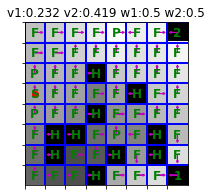

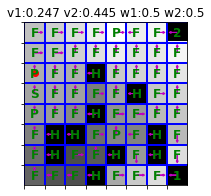

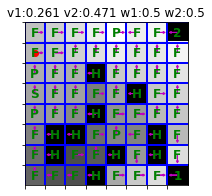

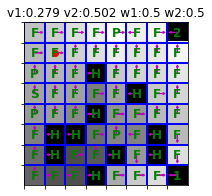

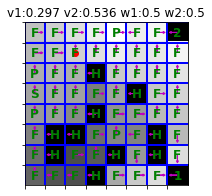

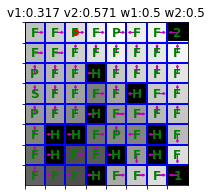

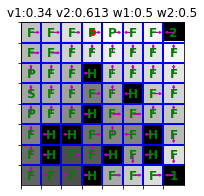

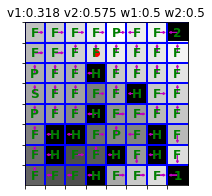

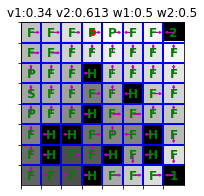

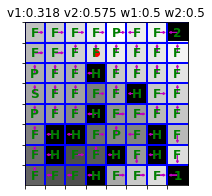

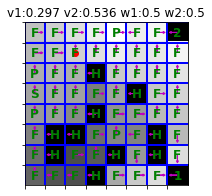

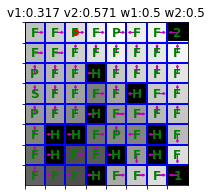

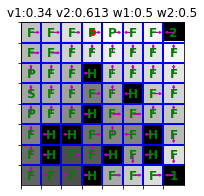

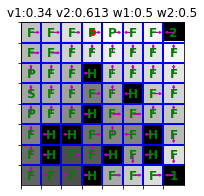

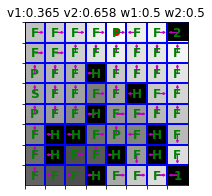

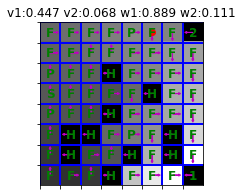

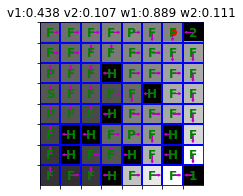

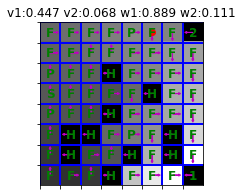

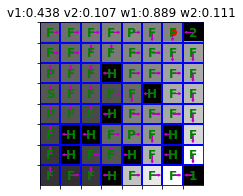

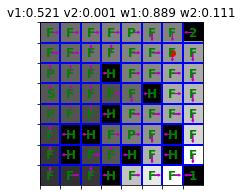

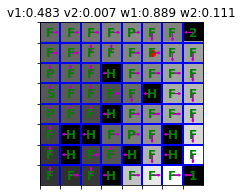

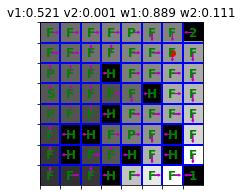

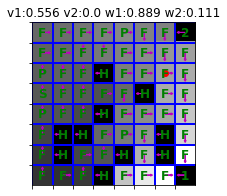

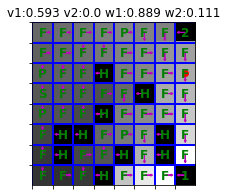

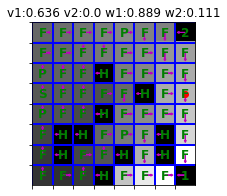

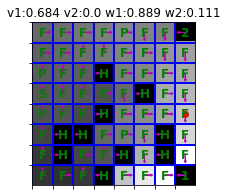

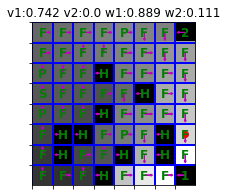

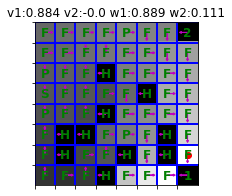

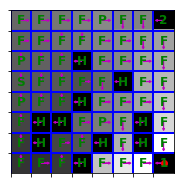

In [21]:
true_mdp = mdp1#ParamFrozenLakeEnvMultigoal(diffs,is_slippery=True,partial_slip=0.1)#, map_name="4x4_multigoal"))
#good combos: 
execute_plan(true_mdp, conditional_plan)

In [ ]:
mdp1 = FrozenLakeEnvMultigoal(is_slippery=True, goal=1)
mdp2 = FrozenLakeEnvMultigoal(is_slippery=True, goal=2)
mdp2.P[9][2] = [(0.45, 17, 0.0), (0.1, 10, 0.0), (0.45, 1, 0.0)]
conditional_plan, err = approximate_NOC_err([mdp1,mdp2],values=True, horizon=3)
print(err)

In [ ]:
true_mdp = FrozenLakeEnvMultigoal(is_slippery=True)#, map_name="4x4_multigoal"))
#good combos: 
true_mdp.seed(4)
print(conditional_plan[0])
execute_plan(true_mdp, conditional_plan)

In [112]:
nR = 2
nT = 2
mdp = ClimateControlEnv(num_rooms=nR, max_steps=20)
s1 = mdp.temps_to_s((0,0,0))
s2 = mdp.temps_to_s((1,1,1))

prefs1 = [(1,10),(1,3),(1,1),(1,1),(1,1),(1,1)]
prefs2 = [(0,10),(0,1),(1,3),(1,1),(1,1),(0,1)]
prefs3 = [(0,10),(1,10),(1,1),(1,1),(1,1),(1,1)]
diffs1 = {s1:{(0,1):[0.05,0.05,0,0.9],(1,1):[0.05,0.05,0,0.9]},
         s2:{(0,1):[0.05,0.05,0.9,0],(1,1):[0.05,0.05,0.9,0]}}

In [115]:
mdp1 = ClimateControlEnv(0.0,0.0,prefs1,num_rooms=nR, num_temps=nT, alt_dynamics_probs=diffs1)
mdp2 = ClimateControlEnv(0.0,0.0,prefs2,num_rooms=nR, num_temps=nT)
mdp3 = ClimateControlEnv(0.0,0.0,prefs3,num_rooms=nR, num_temps=nT)

mdps = [mdp1,mdp2,mdp3]
conditional_plan, err = approximate_NOC(mdps,values=True, horizon=5)

/Users/mckane/anaconda2/envs/nrl3/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


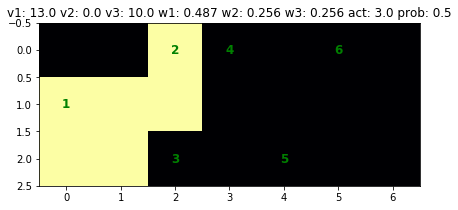

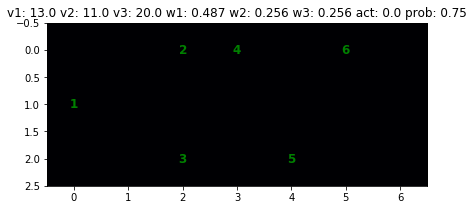

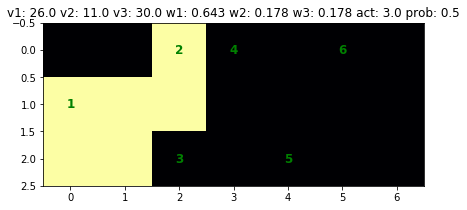

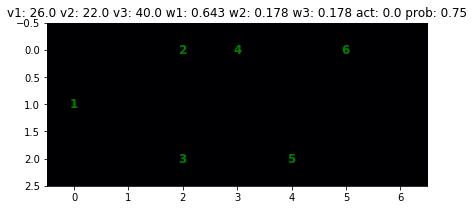

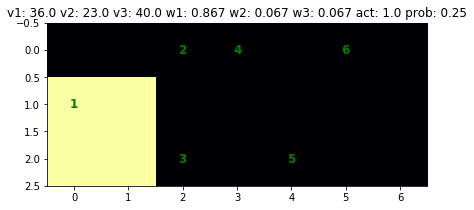

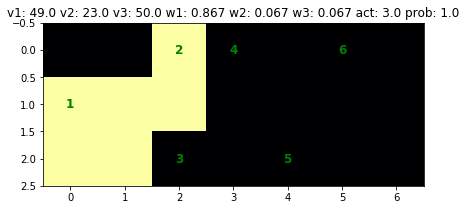

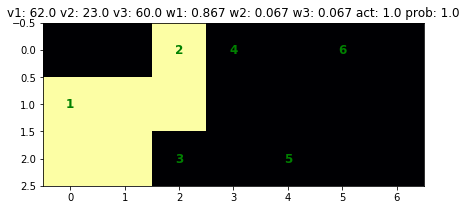

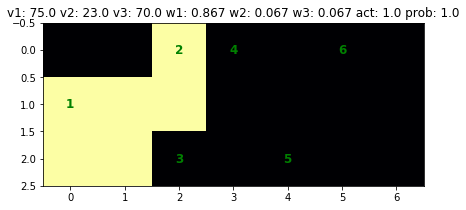

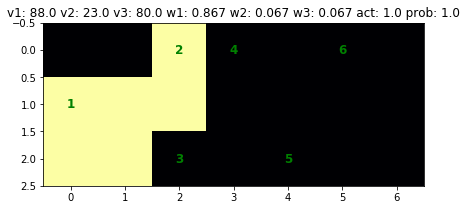

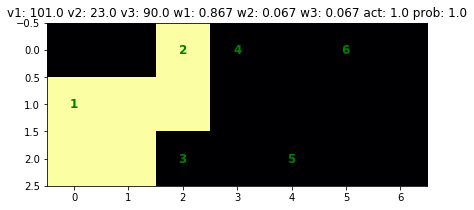

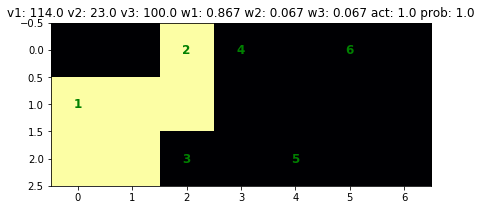

In [153]:
true_mdp = ClimateControlEnv(num_rooms=nR, num_temps=nT, max_steps=10)
#good combos: 
true_mdp.seed(10)
execute_NOC_climate_plan(mdps,true_mdp, conditional_plan)

In [142]:
from valueIteration import ValueIteration
from negotiablegame import NegotiableGame

In [146]:
true_mdp = ClimateControlEnv(num_rooms=nR, num_temps=nT, max_steps=10)
#good combos: 
true_mdp.seed(10)
game = NegotiableGame(true_mdp,mdps,gamma=GAMMA)

In [147]:
valiter = ValueIteration(game, 3)

In [123]:
alph = valiter.valueIteration()

Beginning Value Iteration with Horizon 3

Time : 3
Generating New Alphas with 4 Alphas

Time : 2
Generating New Alphas with 15 Alphas

Time : 1
Generating New Alphas with 98 Alphas


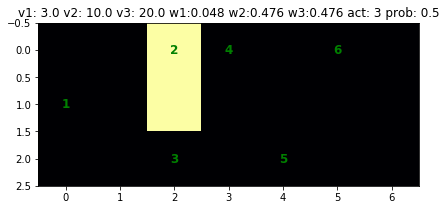

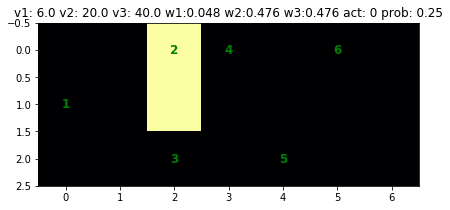

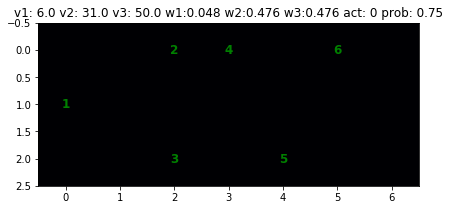

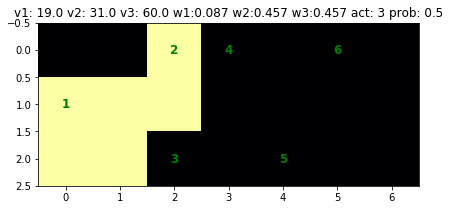

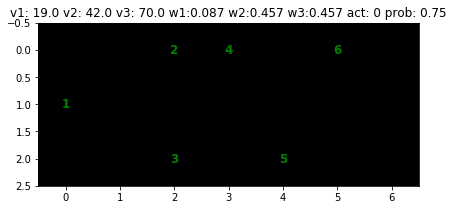

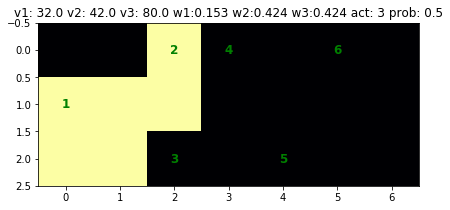

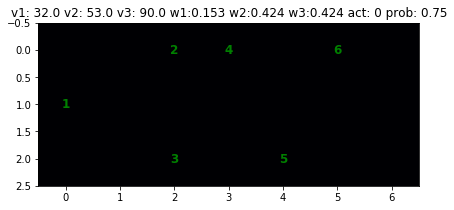

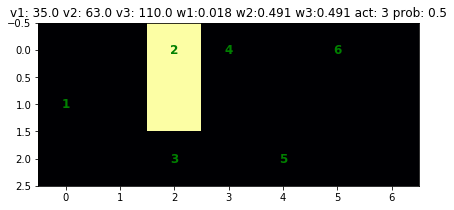

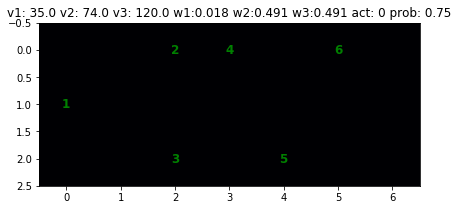

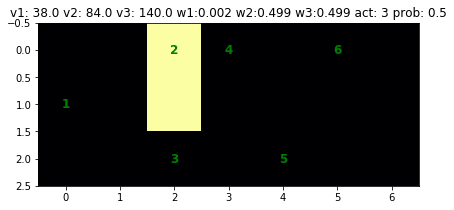

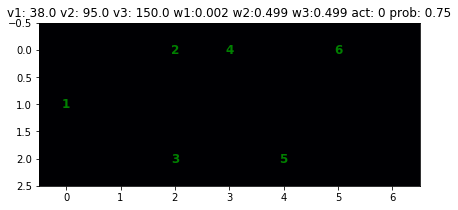

In [148]:
# import pickle as pkl
# alph = pkl.load(open("alpha_dict.pkl", 'rb'))
valiter = ValueIteration(game, 3)
valiter.alpha_dict = alph
execute_alt_climate_plan(game,valiter)